In [309]:
import numpy as np
import matplotlib.pyplot as plt
from stlpy.systems import LinearSystem
from stlpy.STL import LinearPredicate
from stlpy.solvers import GurobiMICPSolver

In [459]:
# drone parameters
m = 20 # mass of the drone
thrust_max = 200 # absolute maximum thrust
u_min = -thrust_max*np.ones(3,) # minimum thrust
u_max = thrust_max*np.ones(3,) # maximum thrust

In [460]:
# State space model

# x_dot = Ax + Bu
# y = Cx + Du
# x = [u, v, w, x, y, z]
# u = [Fx, Fy, Fz]

A = np.zeros((6,6))
A[3,0] = 1
A[4,1] = 1
A[5,2] = 1

B = np.zeros((6,3))
B[0,0] = 1/m
B[1,1] = 1/m
B[2,2] = 1/m

C = np.zeros((6,6))
for i in range(6):  
    C[i,i] = 1

D = np.zeros((6,3))


In [461]:
def inside_cuboid_formula(bounds):
       """
       Create an STL formula representing being inside a
       cuboid with the given bounds:

       ::
                   +-------------------+ z_max
                  / |                 /|
                 /  |                / |
                +-------------------+  |
         y_max  |   +               |  + z_min
                |  /                | /
                | /                 |/
      y_min     +-------------------+
                x_min              x_max

       :param bounds:      Tuple ``(x_min, x_max, y_min, y_max, z_min, z_max)`` 
                            containing the bounds of the cuboid. 

       :return inside_cuboid:   An ``STLFormula`` specifying being inside the
                                   cuboid at time zero.
       """

       # Unpack the bounds
       x_min, x_max, y_min, y_max, z_min, z_max = bounds

       # Create predicates a*y >= b for each side of the cuboid
       a1 = np.zeros((1,6)); a1[:,3] = 1
       right = LinearPredicate(a1, x_min)
       left = LinearPredicate(-a1, -x_max)

       a2 = np.zeros((1,6)); a2[:,4] = 1
       front = LinearPredicate(a2, y_min)
       back = LinearPredicate(-a2, -y_max)

       a3 = np.zeros((1,6)); a3[:,5] = 1
       top = LinearPredicate(a3, z_min)
       bottom = LinearPredicate(-a3, -z_max)

       # Take the conjuction across all the sides
       inside_cuboid = right & left & front & back & top & bottom

       return inside_cuboid


def outside_cuboid_formula(bounds):
       """
       Create an STL formula representing being outside a
       cuboid with the given bounds:

       ::
                   +-------------------+ z_max
                  / |                 /|
                 /  |                / |
                +-------------------+  |
         y_max  |   +               |  + z_min
                |  /                | /
                | /                 |/
      y_min     +-------------------+
                x_min              x_max

       :param bounds:      Tuple ``(x_min, x_max, y_min, y_max, z_min, z_max)`` 
                            containing the bounds of the rectangle. 
       
       :return outside_cuboid:   An ``STLFormula`` specifying being outside the
                                   cuboid at time zero.
       """

       # Unpack the bounds
       x_min, x_max, y_min, y_max, z_min, z_max = bounds

       # Create predicates a*y >= b for each side of the rectangle
       a1 = np.zeros((1,6)); a1[:,3] = 1
       right = LinearPredicate(a1, x_max)
       left = LinearPredicate(-a1, -x_min)

       a2 = np.zeros((1,6)); a2[:,4] = 1
       front = LinearPredicate(a2, y_max)
       back = LinearPredicate(-a2, -y_min)

       a3 = np.zeros((1,6)); a3[:,5] = 1
       top = LinearPredicate(a3, z_max)
       bottom = LinearPredicate(-a3, -z_min)

       # Take the disjuction across all the sides
       outside_cuboid = right | left | front | back | top | bottom

       return outside_cuboid

In [462]:
sys = LinearSystem(A,B,C,D)
x0 = np.array([0,0,-1,0,0,0])

In [463]:
goal1_bounds = (4, 5, 4, 5, 4, 5)
goal2_bounds = (-5, -4, -5, -4, -5, -4)
goal3_bounds = (-6,-5,-5,-4,-5,-4)
obstacle_bounds = (-1.5, -0.5, -1.5, -0.5, -1.5, -0.5)

In [464]:
T = 10
pi1 = inside_cuboid_formula(goal1_bounds)
pi2 = inside_cuboid_formula(goal2_bounds)
pi3 = inside_cuboid_formula(goal3_bounds)
pi4 = outside_cuboid_formula(obstacle_bounds)
spec = pi1.eventually(0, T) & pi2.eventually(0, T)& pi3.eventually(0,T) & pi4.always(0, T)

In [465]:
Q = np.zeros((6,6))
R = np.eye(3)

In [466]:
solver = GurobiMICPSolver(spec, sys, x0, T)
solver.AddQuadraticCost(Q=Q, R=R)
solver.AddControlBounds(u_min, u_max)
x, u, _, _ = solver.Solve()

Setting up optimization problem...
Setup complete in 0.8693716526031494 seconds.
<class 'gurobipy.MQuadExpr'>
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1133 rows, 921 columns and 2541 nonzeros
Model fingerprint: 0x1c88dd79
Model has 33 quadratic objective terms
Variable types: 657 continuous, 264 integer (264 binary)
Coefficient statistics:
  Matrix range     [5e-02, 1e+03]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 896 rows and 803 columns
Presolve time: 0.00s
Presolved: 237 rows, 118 columns, 747 nonzeros
Presolved model has 27 quadratic objective terms
Variable types: 28 continuous, 90 integer (90 binary)
Found heuristic solution: objective 48300.000000
Found heur

In [467]:
u

array([[-100.,   80.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.],
       [ -80.,   80.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.],
       [ -80.,   80.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.]])

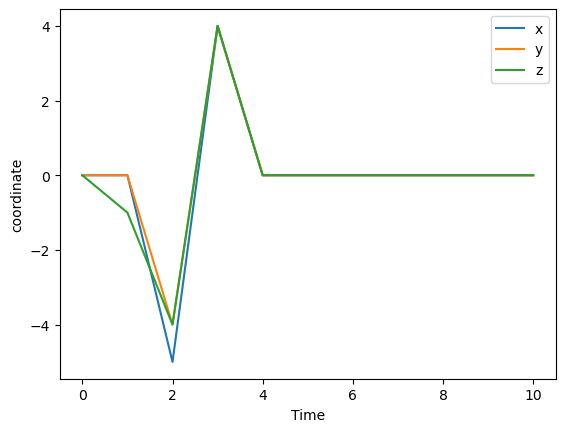

In [468]:
# plot the trajectory
labels = ["u", "v", "w", "x", "y", "z"]

for i in range(3):
    plt.plot(x[i+3,:], label=labels[i+3])

plt.legend()
plt.xlabel("Time")
plt.ylabel("coordinate")
plt.show()

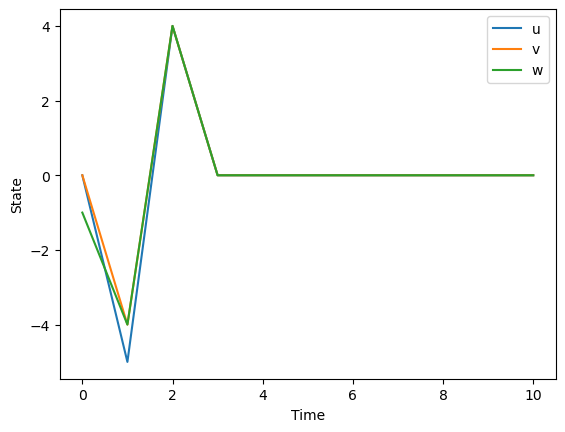

In [469]:
# plot the velocity
for i in range(3):
    plt.plot(x[i,:], label=labels[i])

plt.legend()
plt.xlabel("Time")
plt.ylabel("State")
plt.show()

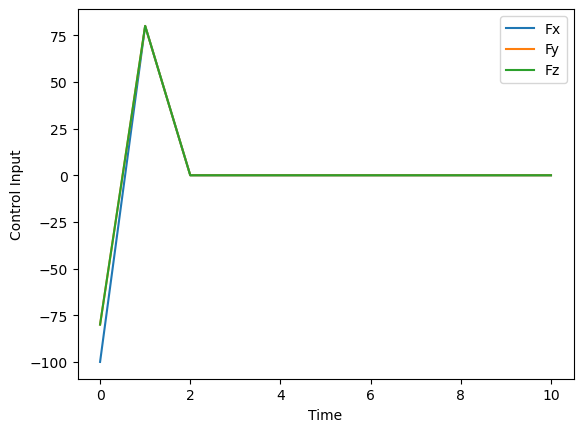

In [470]:
# plot the control inputs
labels = ["Fx", "Fy", "Fz"]
for i in range(3):
    plt.plot(u[i,:])

plt.legend(labels)
plt.xlabel("Time")
plt.ylabel("Control Input")
plt.show()

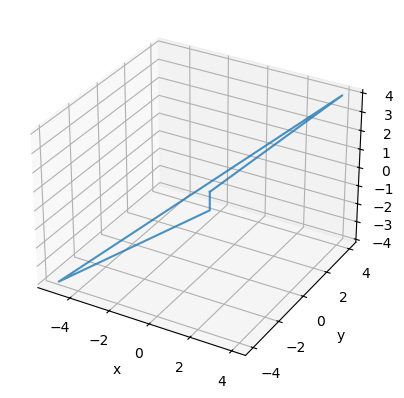

In [477]:
times = [i for i in range(T+1)]
cm = plt.get_cmap("RdYlGn")
fig = plt.figure()
ax = plt.axes(projection='3d')
p = ax.plot3D(x[3,:], x[4,:], x[5,:], alpha=0.8)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()